In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import numpy as np
import joblib
from sqlalchemy import create_engine


## 1. Get data

In [2]:
username = 'rodrigo'
host = 'localhost'           
port = '5432'               
database = 'futmondo'

engine = create_engine(f'postgresql+psycopg2://{username}@{host}:{port}/{database}')
query = "SELECT * FROM full_training_data"
df = pd.read_sql(query, engine)
df.shape

(1340, 39)

In [3]:
# df=pd.read_csv('data/final_dataset/futmondo_final_dataset.csv')
# df.shape

## 2. Build the model

In [4]:
# Corrected feature columns
feature_columns = [
    'home_average',
    'away_average', 
    'overall_average', 
    'last_3_average', 
    'current_price',
    'max_price', 
    'min_price', 
    'is_home_target', 
    'match_minus_1',
    'match_minus_2', 
    'match_minus_3',
    'matchup_prob_win', 
    'matchup_prob_draw', 
    'matchup_prob_loss', 
    'is_home',
    'form_trend', 
    'home_away_diff', 
    'price_vs_max',
    'price_volatility', 
    'recent_momentum', 
    'home_form_interaction',
    'away_form_interaction', 
    'matchup_strength',
    'team_expected_performance', 
    'delantero_matchup_bonus',
    'centrocampista_matchup_bonus', 
    'defensa_matchup_bonus',
    'portero_matchup_bonus', 
    'home_matchup_boost', 
    'difficult_matchup',
    'easy_matchup']

In [5]:
# Drop rows where target_points or any feature is NaN
df_clean = df.dropna(subset=['target_points'] + feature_columns)

X = df_clean[feature_columns]
y = df_clean['target_points']

In [6]:
df_clean.shape

(1134, 39)

In [7]:
# # Check for NaN values first
# print("NaN values per column:")
# print(X.isna().sum())
# print(f"\nTotal NaN values: {X.isna().sum().sum()}")

# # Option 1: Drop rows with NaN values (if not too many)
# X_clean = X.dropna()
# y_clean = y[X_clean.index]

# print(f"\nRows before: {len(X)}, Rows after: {len(X_clean)}")

In [8]:
# Scale features for better performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

# Ensemble model with multiple algorithms
gb_model = GradientBoostingRegressor(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)

ridge_model = Ridge(alpha=10.0, random_state=42)

rf_model = RandomForestRegressor(
    n_estimators=150,
    max_depth=12,
    min_samples_split=8,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42
)

# Voting ensemble combines predictions from all models
model = VotingRegressor(
    estimators=[
        ('gb', gb_model),
        ('rf', rf_model),
        ('ridge', ridge_model)
    ],
    weights=[2, 2, 1]  # Give more weight to tree-based models
)

# Train the ensemble
model.fit(X_train, y_train)

,estimators,"[('gb', ...), ('rf', ...), ...]"
,weights,"[2, 2, ...]"
,n_jobs,None
,verbose,False
,loss,'squared_error'
,learning_rate,0.05
,n_estimators,150
,subsample,0.8
,criterion,'friedman_mse'
,min_samples_split,10
,min_samples_leaf,4


In [9]:
# ===== PREDICTIONS =====
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Create predictions dataframe for test set
test_indices = len(y_test)
predictions_df = pd.DataFrame({
    'actual_points': y_test,
    'predicted_points': y_pred_test,
    'error': y_test - y_pred_test,
    'abs_error': np.abs(y_test - y_pred_test)})

In [10]:
# # Add original features (unscaled) for context
# X_test_unscaled = X.iloc[y_test.index] if hasattr(y_test, 'index') else X.iloc[-len(y_test):]
# predictions_df = pd.concat([predictions_df.reset_index(drop=True), 
#                             X_test_unscaled.reset_index(drop=True)], axis=1)

# print("===== PREDICTIONS SAMPLE =====")
# print(predictions_df[['actual_points', 'predicted_points', 'error', 'abs_error', 
#                       'overall_average', 'last_3_average', 'is_home_target']].head(10))
# print(f"\nMean Absolute Error: {predictions_df['abs_error'].mean():.3f}")
# print(f"Root Mean Squared Error: {np.sqrt((predictions_df['error']**2).mean()):.3f}")

In [11]:
# ===== FEATURE IMPORTANCE =====
# Access the fitted models from the VotingRegressor
gb_importance = model.named_estimators_['gb'].feature_importances_
rf_importance = model.named_estimators_['rf'].feature_importances_

# Average importance across models
avg_importance = (gb_importance * 2 + rf_importance * 2) / 4

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': avg_importance,
    'gb_importance': gb_importance,
    'rf_importance': rf_importance
}).sort_values('importance', ascending=False)

print("\n===== FEATURE IMPORTANCE =====")
print(feature_importance_df)


===== FEATURE IMPORTANCE =====
                         feature  importance  gb_importance  rf_importance
6                      min_price    0.082296       0.075762       0.088829
19               recent_momentum    0.076293       0.080814       0.071771
2                overall_average    0.075398       0.082577       0.068219
4                  current_price    0.062274       0.058559       0.065989
8                  match_minus_1    0.054364       0.057562       0.051165
15                    form_trend    0.054119       0.064776       0.043462
12             matchup_prob_draw    0.051737       0.068491       0.034982
1                   away_average    0.047963       0.040294       0.055631
5                      max_price    0.039451       0.025976       0.052926
24       delantero_matchup_bonus    0.036369       0.047699       0.025040
3                 last_3_average    0.034708       0.029666       0.039750
21         away_form_interaction    0.034089       0.043531       0.

Save the model

In [14]:
import joblib

# After training your model
model_package = {
    'model': model,
    'scaler': scaler,
    'feature_columns': feature_columns
}

joblib.dump(model_package, 'data/model/fantasy_model_complete.pkl')

['data/model/fantasy_model_complete.pkl']

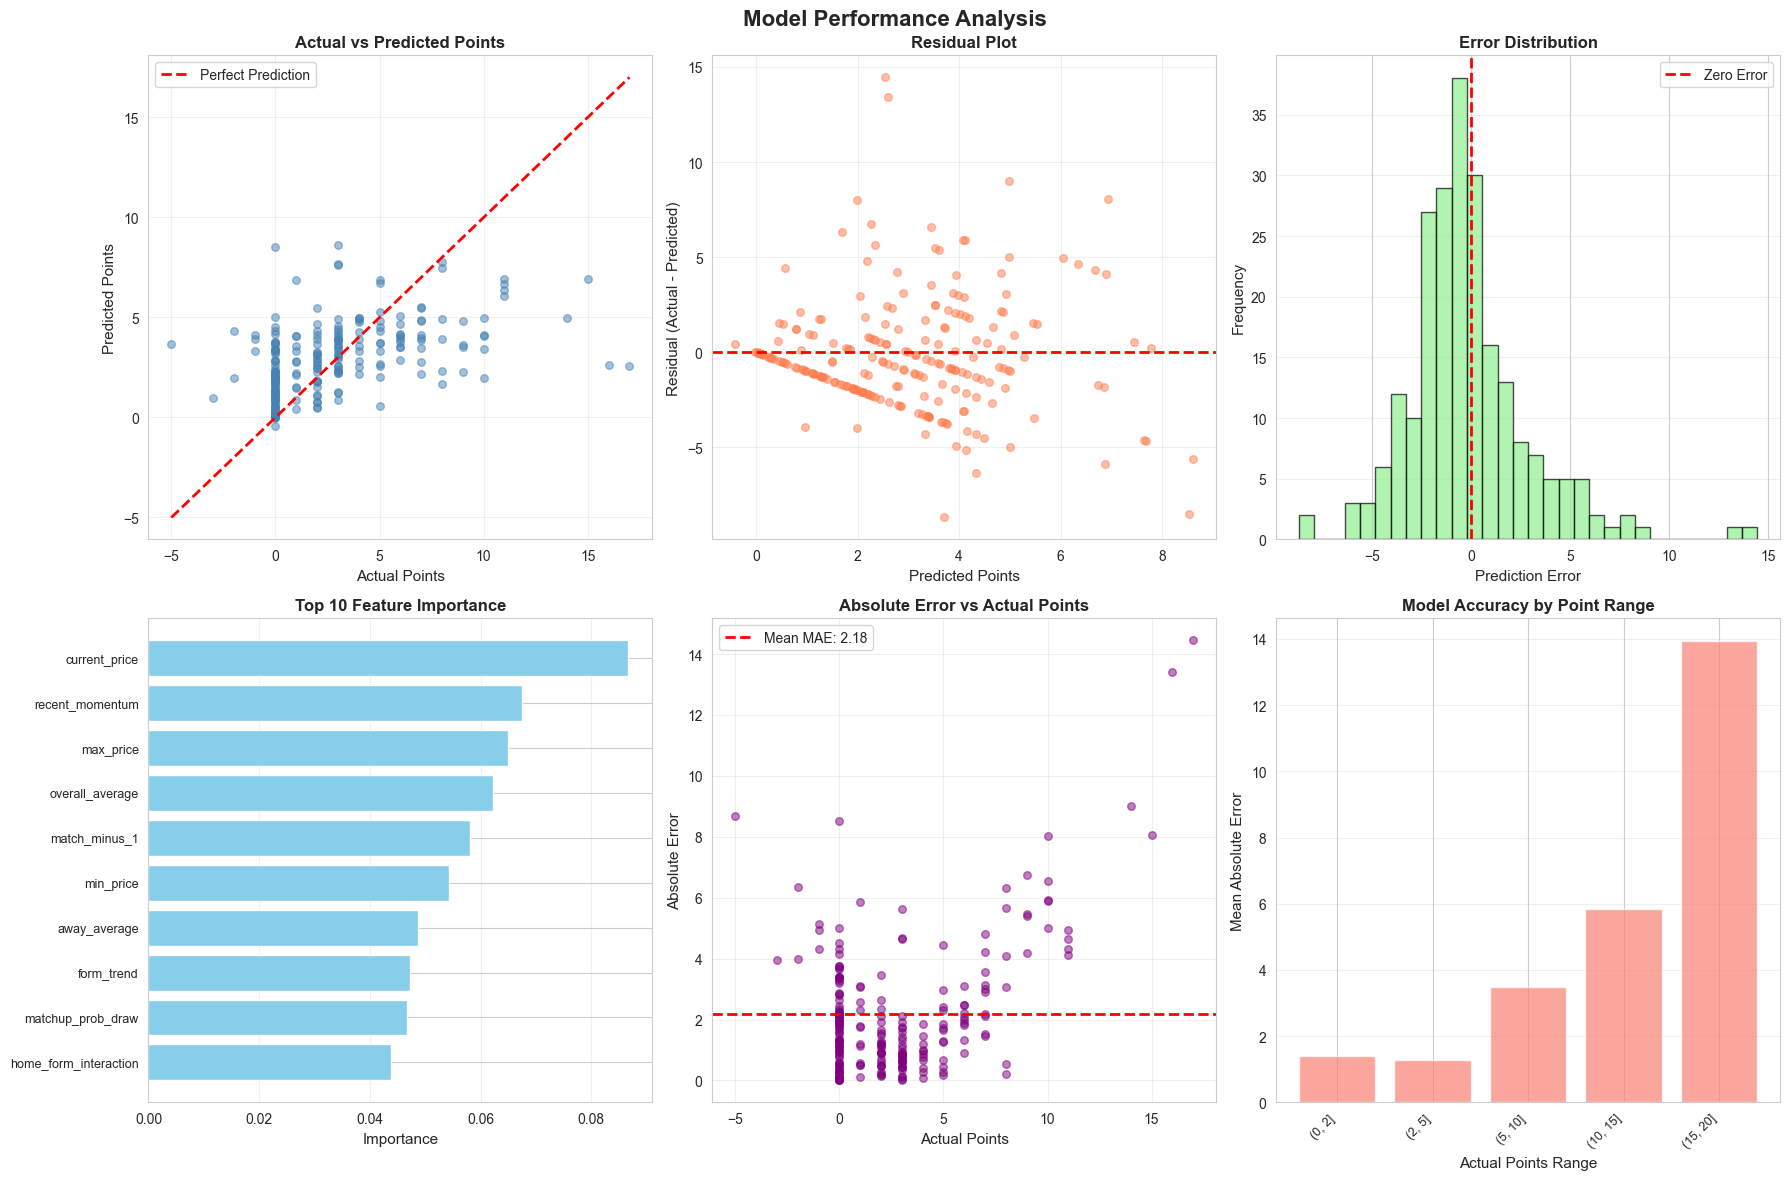


===== DETAILED PERFORMANCE METRICS =====
Mean Absolute Error (MAE): 2.178
Root Mean Squared Error (RMSE): 3.061
Median Absolute Error: 1.587
Max Error: 14.453
Predictions within 2 points: 60.8%
Predictions within 5 points: 90.7%

R² Score: 0.221


In [15]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold')

# 1. Actual vs Predicted Scatter Plot
axes[0, 0].scatter(predictions_df['actual_points'], predictions_df['predicted_points'], 
                   alpha=0.5, s=30, c='steelblue')
# Perfect prediction line
min_val = min(predictions_df['actual_points'].min(), predictions_df['predicted_points'].min())
max_val = max(predictions_df['actual_points'].max(), predictions_df['predicted_points'].max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Points', fontsize=11)
axes[0, 0].set_ylabel('Predicted Points', fontsize=11)
axes[0, 0].set_title('Actual vs Predicted Points', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Residual Plot (errors)
axes[0, 1].scatter(predictions_df['predicted_points'], predictions_df['error'], 
                   alpha=0.5, s=30, c='coral')
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Points', fontsize=11)
axes[0, 1].set_ylabel('Residual (Actual - Predicted)', fontsize=11)
axes[0, 1].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Error Distribution
axes[0, 2].hist(predictions_df['error'], bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 2].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0, 2].set_xlabel('Prediction Error', fontsize=11)
axes[0, 2].set_ylabel('Frequency', fontsize=11)
axes[0, 2].set_title('Error Distribution', fontsize=12, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3, axis='y')

# 4. Feature Importance (Top 10)
top_features = feature_importance_df.head(10)
axes[1, 0].barh(range(len(top_features)), top_features['importance'], color='skyblue')
axes[1, 0].set_yticks(range(len(top_features)))
axes[1, 0].set_yticklabels(top_features['feature'], fontsize=9)
axes[1, 0].set_xlabel('Importance', fontsize=11)
axes[1, 0].set_title('Top 10 Feature Importance', fontsize=12, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 5. Absolute Error vs Actual Points
axes[1, 1].scatter(predictions_df['actual_points'], predictions_df['abs_error'], 
                   alpha=0.5, s=30, c='purple')
axes[1, 1].axhline(y=predictions_df['abs_error'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f'Mean MAE: {predictions_df["abs_error"].mean():.2f}')
axes[1, 1].set_xlabel('Actual Points', fontsize=11)
axes[1, 1].set_ylabel('Absolute Error', fontsize=11)
axes[1, 1].set_title('Absolute Error vs Actual Points', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Prediction Accuracy Bins
bins = [0, 2, 5, 10, 15, 20, 30]
predictions_df['actual_bin'] = pd.cut(predictions_df['actual_points'], bins=bins)
accuracy_by_bin = predictions_df.groupby('actual_bin', observed=True)['abs_error'].mean()
axes[1, 2].bar(range(len(accuracy_by_bin)), accuracy_by_bin.values, color='salmon', alpha=0.7)
axes[1, 2].set_xticks(range(len(accuracy_by_bin)))
axes[1, 2].set_xticklabels([str(x) for x in accuracy_by_bin.index], rotation=45, ha='right', fontsize=9)
axes[1, 2].set_xlabel('Actual Points Range', fontsize=11)
axes[1, 2].set_ylabel('Mean Absolute Error', fontsize=11)
axes[1, 2].set_title('Model Accuracy by Point Range', fontsize=12, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model_performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional summary statistics
print("\n===== DETAILED PERFORMANCE METRICS =====")
print(f"Mean Absolute Error (MAE): {predictions_df['abs_error'].mean():.3f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt((predictions_df['error']**2).mean()):.3f}")
print(f"Median Absolute Error: {predictions_df['abs_error'].median():.3f}")
print(f"Max Error: {predictions_df['abs_error'].max():.3f}")
print(f"Predictions within 2 points: {(predictions_df['abs_error'] <= 2).sum() / len(predictions_df) * 100:.1f}%")
print(f"Predictions within 5 points: {(predictions_df['abs_error'] <= 5).sum() / len(predictions_df) * 100:.1f}%")
print(f"\nR² Score: {model.score(X_test, y_test):.3f}")

In [16]:
# Group highly correlated features and keep only the best from each group
correlation_matrix = df[feature_columns].corr()
correlation_matrix

,home_average,away_average,overall_average,last_3_average,current_price,max_price,min_price,is_home_target,match_minus_1,match_minus_2,...,away_form_interaction,matchup_strength,team_expected_performance,delantero_matchup_bonus,centrocampista_matchup_bonus,defensa_matchup_bonus,portero_matchup_bonus,home_matchup_boost,difficult_matchup,easy_matchup
home_average,1.000000,0.651096,0.926525,0.581082,0.709280,0.712077,0.707168,0.018369,0.432318,0.440161,...,0.276889,0.156458,0.163029,0.217984,0.158148,-0.134485,-0.144970,0.103176,-0.062897,0.159711
away_average,0.651096,1.000000,0.876948,0.553684,0.596218,0.597514,0.594044,0.013273,0.418160,0.425343,...,0.439194,0.127468,0.129493,0.246180,0.145580,-0.199448,-0.119500,0.051471,-0.044495,0.113522
overall_average,0.926525,0.876948,1.000000,0.624083,0.719354,0.721526,0.717000,0.019056,0.467294,0.475859,...,0.378945,0.160872,0.165981,0.263286,0.166154,-0.186897,-0.145342,0.088879,-0.064517,0.158093
last_3_average,0.581082,0.553684,0.624083,1.000000,0.487021,0.490889,0.489351,-0.028077,0.745129,0.780750,...,0.274814,0.124921,0.127480,0.134154,0.138711,-0.124957,-0.072484,0.038069,-0.056272,0.122556
current_price,0.709280,0.596218,0.719354,0.487021,1.000000,0.999787,0.999763,0.009645,0.357203,0.370939,...,0.256908,0.325078,0.338152,0.273087,0.321166,-0.273565,-0.043843,0.170279,-0.126544,0.327270
max_price,0.712077,0.597514,0.721526,0.490889,0.999787,1.000000,0.999744,0.009613,0.359819,0.373853,...,0.257626,0.324967,0.338024,0.273979,0.320458,-0.272973,-0.045489,0.170247,-0.126200,0.327111
min_price,0.707168,0.594044,0.717000,0.489351,0.999763,0.999744,1.000000,0.009263,0.358168,0.372583,...,0.256455,0.325601,0.338668,0.271466,0.322279,-0.273311,-0.043093,0.169890,-0.127158,0.327277
is_home_target,0.018369,0.013273,0.019056,-0.028077,0.009645,0.009613,0.009263,1.000000,-0.042719,0.030051,...,-0.766793,0.389821,0.391350,0.100278,0.084338,0.123018,-0.003977,0.835709,-0.172494,0.295725
match_minus_1,0.432318,0.418160,0.467294,0.745129,0.357203,0.359819,0.358168,-0.042719,1.000000,0.382459,...,0.215066,0.090315,0.091636,0.114733,0.087863,-0.092750,-0.060144,0.003641,-0.030212,0.105406
match_minus_2,0.440161,0.425343,0.475859,0.780750,0.370939,0.373853,0.372583,0.030051,0.382459,1.000000,...,0.169643,0.133708,0.135156,0.109808,0.121784,-0.089774,-0.050747,0.091476,-0.080696,0.102264


In [14]:
from training_database import get_player_features
import pandas as pd

In [15]:
df_info=get_player_features('Witsel', 16)

In [16]:
df_info=pd.DataFrame([df_info])

In [8]:
import pandas as pd

In [9]:
# features_df = pd.DataFrame([df_info])

In [9]:
features_df

,home_average,away_average,overall_average,last_3_average,current_price,max_price,min_price,is_home_target,match_minus_1,match_minus_2,...,away_form_interaction,matchup_strength,team_expected_performance,delantero_matchup_bonus,centrocampista_matchup_bonus,defensa_matchup_bonus,portero_matchup_bonus,home_matchup_boost,difficult_matchup,easy_matchup
0,3.285714,4.4,3.75,9.0,6261904,7052986,6261904,True,14,7,...,0.0,0.319917,1.845495,0.0,0.0,0.659958,0.0,0.262789,0,1


In [ ]:
get_futmondo_points(player_name: str, round_number: int)